In [111]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import Counter

Rail and bus modes are very different from each other, and so there is a good argument to be made to analyze the factors that contribute to their ridership separately. We have a lot of different variables to use for analysis, so the first thing we need to do is collect all the data from the spreadsheets into one large dataframe.

## Collecting Data

In [ ]:
# Load individual data frames.
cap_exp = pd.read_csv("../../data/NTD_Capital_Expenditures.csv")
riders = pd.read_csv("../../data/NTD_Annual_Ridership.csv", dtype={'NTD ID':str})
fares = pd.read_csv("../../data/NTD_Fare_Revenue.csv", dtype={'NTD ID':str})
maj_safety = pd.read_csv("../../data/NTD_Major_Safety_Incidents.csv", dtype={'NTD ID':str})
nonmaj_safe = pd.read_csv("../../data/NTD_NonMajor_Safety_Incidents.csv", dtype={'NTD ID':str})

In [21]:
# Drop columns not needed for joins later.
fares.drop(columns=['Agency Name', 'Reporter Type'], inplace=True)
# Rename columns for later joining.
nonmaj_safe.rename(columns={"Customer Injuries":"Customer Minor Injuries", "Worker Injuries":"Worker Minor Injuries",
                    "Other Injuries":"Other Minor Injuries","Total Injuries":"Total Minor Injuries"}, inplace=True)

### Aggregate Capital Expenses
Capital expenses data is listed as every entity operated or associated with the agencies, so some modes may be duplicated. A good idea would be to first aggregate on the columns.

In [22]:
cap_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25322 entries, 0 to 25321
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Agency                               25322 non-null  object 
 1   City                                 25279 non-null  object 
 2   State                                25322 non-null  object 
 3   NTD ID                               25322 non-null  object 
 4   Reporter Type                        25322 non-null  object 
 5   Report Year                          25322 non-null  int64  
 6   Primary UZA Population               24733 non-null  float64
 7   Agency VOMS                          25322 non-null  object 
 8   Mode                                 25117 non-null  object 
 9   TOS                                  25117 non-null  object 
 10  Mode VOMS                            25304 non-null  object 
 11  Guideway                    

In [23]:
cap_exp.drop(columns=['City', 'TOS', 'Agency'], inplace=True)
cap_exp.insert(5, 'Year', value=cap_exp['Report Year'])
cap_exp.drop(columns=['Report Year', 'Agency VOMS'], inplace=True)

In [24]:
# Transform NTD ID to turn it into 5-digit form or shorter.
cap_exp['NTD ID'] = [str(num)[-5:] for num in cap_exp['NTD ID']]
# Transform Mode VOMS to numeric.
cap_exp['Mode VOMS'] = [str(num).replace(',','') for num in cap_exp['Mode VOMS']]
cap_exp['Mode VOMS'] = cap_exp['Mode VOMS'].astype('float64')
# Print column inforamation.
cap_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25322 entries, 0 to 25321
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                25322 non-null  object 
 1   NTD ID                               25322 non-null  object 
 2   Reporter Type                        25322 non-null  object 
 3   Primary UZA Population               24733 non-null  float64
 4   Year                                 25322 non-null  int64  
 5   Mode                                 25117 non-null  object 
 6   Mode VOMS                            25304 non-null  float64
 7   Guideway                             25322 non-null  float64
 8   Stations                             25322 non-null  float64
 9   Administrative Buildings             25322 non-null  float64
 10  Maintenance Buildings                25322 non-null  float64
 11  Passenger Vehicles          

In [25]:
# Grab categorical types inside the data frame.
exp_cat = cap_exp.drop(columns=cap_exp.columns[6:])
# Grab numeric values.
exp_num = cap_exp.drop(columns=['State','Reporter Type','Primary UZA Population'])
# Group by ID, Year, and Mode
exp_grp_cat = exp_cat.groupby(by=['NTD ID', 'Mode', 'Year'])
exp_grp_num = exp_num.groupby(by=['NTD ID', 'Mode', 'Year'])

In [26]:
# Define code to handle categorical data.
def most_common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

exp_cat_agg = exp_grp_cat.agg(most_common).reset_index()
exp_num_agg = exp_grp_num.sum().reset_index()
# Handle 0 population values by replacing them with nan.
exp_cat_agg['Primary UZA Population'] = exp_cat_agg['Primary UZA Population'].replace(0.0, np.nan)

In [27]:
# Combine the two data frames back into one entity.
cap_exp = exp_cat_agg.merge(exp_num_agg, on=['NTD ID', 'Mode', 'Year'], how='left')
cap_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23950 entries, 0 to 23949
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   NTD ID                               23950 non-null  object 
 1   Mode                                 23950 non-null  object 
 2   Year                                 23950 non-null  int64  
 3   State                                23950 non-null  object 
 4   Reporter Type                        23950 non-null  object 
 5   Primary UZA Population               12579 non-null  float64
 6   Mode VOMS                            23950 non-null  float64
 7   Guideway                             23950 non-null  float64
 8   Stations                             23950 non-null  float64
 9   Administrative Buildings             23950 non-null  float64
 10  Maintenance Buildings                23950 non-null  float64
 11  Passenger Vehicles          

### Merge Cleaned Datasets

In [28]:
all_dat = cap_exp.merge(riders, on=['NTD ID', 'Mode', 'Year','Reporter Type'])
all_dat.rename(columns={"Other":"Other Spending", "Total":"Total Spending"}, inplace=True)
#all_dat.info()

In [29]:
all_dat = all_dat.merge(fares, on=['NTD ID', 'Year', 'Mode'])
#all_dat.info()

In [30]:
all_dat = all_dat.merge(nonmaj_safe, on=['NTD ID', 'Year', 'Mode'], how='left')
all_dat = all_dat.merge(maj_safety, how='left', on = ['NTD ID', 'Year', 'Mode'])
all_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 75 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   NTD ID                                            6898 non-null   object 
 1   Mode                                              6898 non-null   object 
 2   Year                                              6898 non-null   int64  
 3   State                                             6898 non-null   object 
 4   Reporter Type                                     6898 non-null   object 
 5   Primary UZA Population                            6898 non-null   float64
 6   Mode VOMS                                         6898 non-null   float64
 7   Guideway                                          6898 non-null   float64
 8   Stations                                          6898 non-null   float64
 9   Administrative Buil

## Isolating Rail
Now that we have everything, we can use the `3 Mode` column to pick out only the rail data. There aren't that many rail systems in the US, so it won't be too surprising if our data size drops appreciably, but we should still have plenty of data points to perform a regression analysis. Time to go for it.

In [31]:
rail_dat = all_dat[all_dat['3 Mode'] == 'Rail']
rail_dat.shape

(641, 75)

There really aren't many rail systems in the US. But 641 entries should suffice for a regression. Though perhaps we have our first recommendation right here. Build more rail.

Jokes aside, we can start with a linear regression model, which will require us to choose a set of parameters to fit to. We will stick to numeric variables for now, and see how we do without the complication of the `state` variable, which for rail, at least, would add a bit too many one-hot variables to the problem. Looking at the set of variables, we will choose to fit on the following:
- `Primary UZA Population`
- `Mode VOMS`
- `Total Spending`
- `Total Minor Injuries`
- `Property Damage`
- `Total Injuries`
- `Total Fatalities`
- `Total Serious Injuries`

In addition to the above untransformed variables, we will additionally fit to the calculated quantity `Fare`, which we will define as the total fares divided by the number of trips, thus estimating the cost per trip. The parameter we are trying to estimate is the number of unlinked passenger trips, or `UPT`.

In [32]:
cols = ['Primary UZA Population', 'Mode VOMS', 'Total Spending', 'Total Minor Injuries',
        'Property Damage', 'Total Injuries', 'Total Fatalities', 'Total Serious Injuries']
X_reg = rail_dat.loc[:, cols]
X_reg['Fare'] = rail_dat['Total Fares'] / rail_dat['UPT']
X_reg['UPT'] = rail_dat['UPT']
X_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, 18 to 6840
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Primary UZA Population  641 non-null    float64
 1   Mode VOMS               641 non-null    float64
 2   Total Spending          641 non-null    float64
 3   Total Minor Injuries    332 non-null    float64
 4   Property Damage         381 non-null    float64
 5   Total Injuries          381 non-null    float64
 6   Total Fatalities        381 non-null    float64
 7   Total Serious Injuries  381 non-null    float64
 8   Fare                    632 non-null    float64
 9   UPT                     632 non-null    float64
dtypes: float64(10)
memory usage: 55.1 KB


In [33]:
# Drop entries where our target value is not defined.
X_reg.dropna(subset=['UPT'], inplace=True)
# Replace missing injury values with 0, since no report means no incidents.
X_reg.fillna(0, inplace=True)
X_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 632 entries, 18 to 6840
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Primary UZA Population  632 non-null    float64
 1   Mode VOMS               632 non-null    float64
 2   Total Spending          632 non-null    float64
 3   Total Minor Injuries    632 non-null    float64
 4   Property Damage         632 non-null    float64
 5   Total Injuries          632 non-null    float64
 6   Total Fatalities        632 non-null    float64
 7   Total Serious Injuries  632 non-null    float64
 8   Fare                    632 non-null    float64
 9   UPT                     632 non-null    float64
dtypes: float64(10)
memory usage: 54.3 KB


### Linear Regressions

In [35]:
from sklearn import linear_model
reg_rail = linear_model.LinearRegression()
reg_rail.fit(X = X_reg.drop(columns=['UPT']), y = X_reg['UPT'])

LinearRegression()

In [36]:
# Check the R^2 score for the fit.
reg_rail.score(X_reg.drop(columns=['UPT']), y = X_reg['UPT'])

0.9731997717910549

This looks like a good model given the R^2 term, but it doesn't tell us which parameters were the most useful in predicting the ridership and which were largely extraneous. This is the realm of tests for statistical significance, which scikit-learn does not do. We could code the tests ourselves from scratch, or we could use the Python package `statsmodels`, which supports statistical inference with linear regression.

In [53]:
mod_rail = sm.GLS(X_reg['UPT'], sm.add_constant(X_reg.drop(columns=['UPT'])))
res_rail = mod_rail.fit()
print(res_rail.summary())

                            GLS Regression Results                            
Dep. Variable:                    UPT   R-squared:                       0.973
Model:                            GLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2510.
Date:                Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:11:24   Log-Likelihood:                -11935.
No. Observations:                 632   AIC:                         2.389e+04
Df Residuals:                     622   BIC:                         2.393e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -9.31

Looking at the results, the model does quite well (the same as sklearn) when looking at the $R^2$ metric for goodness-of-fit. However, it has high AIC and BIC values, as well as a large condition number, which suggests that there might be underlying problems with the model not captured by the $R^2$ number. However, just from this table, we can make some general notes. First, we have that the following variables are statistically significant at at least 5%.
- `Mode VOMS` (positive impact)
- `Total Minor Injuries` (positive impact)
- `Total Injuries` (negative impact)
- `Total Fatalities` (negative impact)
- Model intercept (negative)

The suprise is the minor injuries data, which contributes positively to the ridership numbers. One would assume that this quantity is picking up on some underlying population or ridership number, since you would expect injuries to be a negative effect. Let's have a look at the data range and see if something is going on.

In [60]:
X_reg.describe()

,Primary UZA Population,Mode VOMS,Total Spending,Total Minor Injuries,Property Damage,Total Injuries,Total Fatalities,Total Serious Injuries,Fare,UPT
count,6.320000e+02,632.000000,6.320000e+02,632.000000,6.320000e+02,632.000000,632.000000,632.000000,632.000000,6.320000e+02
mean,4.622168e+06,207.283228,1.522172e+08,43.542722,2.095115e+04,16.308544,1.917722,2.628165,3.039687,4.104635e+07
std,5.017122e+06,718.182605,3.670452e+08,223.598274,1.375699e+05,53.939904,8.217113,10.382359,5.331667,2.352635e+08
min,6.901400e+04,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.845000e+03
25%,1.439666e+06,8.000000,1.977776e+06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.800406,7.155575e+05
50%,3.070300e+06,36.000000,2.251667e+07,1.000000,0.000000e+00,0.000000,0.000000,0.000000,1.326981,3.428020e+06
75%,5.441567e+06,108.000000,1.214601e+08,13.000000,0.000000e+00,9.000000,1.000000,1.000000,3.317415,1.794306e+07
max,1.942645e+07,10820.000000,3.421105e+09,2627.000000,2.134153e+06,632.000000,102.000000,135.000000,67.627266,2.723960e+09


We notice a few things. First, that there's an instance of 0 vehicles in maximum service, which doesn't really make sense, so we drop those. And second, that we have a value of a fare that's 67.63 dollars, which is almost unreasonably high. So we can remove some of those outliers and then try and look again. As a general rule of thumb, we don't really expect public transit to have individual fares in excess of 20 dollars a trip, so we'll make that the cutoff (Long airport routes, mountain routes, anything irregular or sporadic. For instance, RTD's AB1 from Boulder to DIA is $11 per trip.).

In [84]:
X_trans_reg = X_reg[X_reg['Mode VOMS'] != 0]
X_trans_reg = X_trans_reg[X_trans_reg['Fare'] <= 20]
X_trans_reg.describe()

,Primary UZA Population,Mode VOMS,Total Spending,Total Minor Injuries,Property Damage,Total Injuries,Total Fatalities,Total Serious Injuries,Fare,UPT
count,6.190000e+02,619.000000,6.190000e+02,619.000000,6.190000e+02,619.000000,619.000000,619.000000,619.000000,6.190000e+02
mean,4.641522e+06,211.030695,1.549257e+08,44.457189,2.139116e+04,16.651050,1.957997,2.683360,2.550127,4.189198e+07
std,5.057328e+06,725.216480,3.703973e+08,225.847665,1.389754e+05,54.451853,8.298332,10.483917,3.119469,2.376518e+08
min,6.901400e+04,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.845000e+03
25%,1.439666e+06,8.000000,1.968839e+06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.798290,7.392360e+05
50%,2.956746e+06,38.000000,2.234056e+07,1.000000,0.000000e+00,0.000000,0.000000,0.000000,1.323231,3.757728e+06
75%,5.148326e+06,109.500000,1.290033e+08,14.000000,0.000000e+00,9.000000,1.000000,1.000000,3.186883,1.823985e+07
max,1.942645e+07,10820.000000,3.421105e+09,2627.000000,2.134153e+06,632.000000,102.000000,135.000000,19.594922,2.723960e+09


One thing that leaps to mind when looking at these numbers is the mismatch in ranges. Some of these numbers are in millions, and some only go up to 100. So, the obvious order of business would be to try to limit the range of values we are operating with. It is probably best to try and keep most of the columns between 0 and 1000 or so. For ranges in which the numbers get staggeringly large, like total `Total Spending` and `Property Damage`, we can cheat a little by replacing all the zero values with the number 1.0. This then allows us to transform these scales logarithmically, drastically cutting down the range of values we're considering. We can also use a logarithm to transform `Mode VOMS`, since that value bottoms out at one. Let's do that.

In [85]:
X_trans_reg['Mode VOMS'] = np.log(X_trans_reg['Mode VOMS'])
X_trans_reg['Total Spending'] = np.log(X_trans_reg['Total Spending'].replace(0.0, 1.0))
X_trans_reg['Property Damage'] = np.log(X_trans_reg['Property Damage'].replace(0.0, 1.0))
X_trans_reg['Primary UZA Population'] = np.log(X_trans_reg['Primary UZA Population'])
X_trans_reg['UPT'] = np.log(X_trans_reg['UPT'])

In [86]:
X_trans_reg.describe()

,Primary UZA Population,Mode VOMS,Total Spending,Total Minor Injuries,Property Damage,Total Injuries,Total Fatalities,Total Serious Injuries,Fare,UPT
count,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000
mean,14.799700,3.594497,15.653320,44.457189,0.884751,16.651050,1.957997,2.683360,2.550127,15.096437
std,1.154038,1.825970,4.952698,225.847665,3.074222,54.451853,8.298332,10.483917,3.119469,2.179951
min,11.142065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.254529
25%,14.179922,2.079442,14.492955,0.000000,0.000000,0.000000,0.000000,0.000000,0.798290,13.513357
50%,14.899600,3.637586,16.921914,1.000000,0.000000,0.000000,0.000000,0.000000,1.323231,15.139325
75%,15.454169,4.695914,18.675341,14.000000,0.000000,9.000000,1.000000,1.000000,3.186883,16.719119
max,16.782146,9.289152,21.953230,2627.000000,14.573580,632.000000,102.000000,135.000000,19.594922,21.725353


These ranges are now a lot closer. We can try fitting again.

In [87]:
mod_trans_rail = sm.GLS(X_trans_reg['UPT'], sm.add_constant(X_trans_reg.drop(columns=['UPT'])))
res_trans_rail = mod_trans_rail.fit()
print(res_trans_rail.summary())

                            GLS Regression Results                            
Dep. Variable:                    UPT   R-squared:                       0.858
Model:                            GLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     408.6
Date:                Mon, 18 Nov 2024   Prob (F-statistic):          2.19e-251
Time:                        17:48:43   Log-Likelihood:                -756.24
No. Observations:                 619   AIC:                             1532.
Df Residuals:                     609   BIC:                             1577.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      7

The $R^2$ metric drops a bit, down to 0.86, but we see an approximately 20-fold improvement in the AIC and BIC as well as a reduction of the condition number by a factor of $10^5$. That is a significant improvement from the un-transformed model. It also gives slightly different results. At the five percent significant level, we obtain the following significant coefficients:
- `log[Primary UZA Population]` (positive)
- `log[Mode VOMS]` (positive)
- `log[Total Spending]` (positive)
- `log[Property Damage]` (positive)
- `Total Fatalities` (negative)
- `Fare` (negative)
- Model Intercept (positive)

We can then try to fit a model using only the above variables.

In [89]:
X_fin_rail = X_trans_reg.drop(columns=['Total Minor Injuries', 'Total Injuries', 'Total Serious Injuries'])
mod_fin_reg = sm.GLS(X_fin_rail['UPT'], sm.add_constant(X_fin_rail.drop(columns=['UPT'])))
res_fin_reg = mod_fin_reg.fit()
print(res_fin_reg.summary())

                            GLS Regression Results                            
Dep. Variable:                    UPT   R-squared:                       0.855
Model:                            GLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     600.7
Date:                Mon, 18 Nov 2024   Prob (F-statistic):          1.15e-252
Time:                        18:04:22   Log-Likelihood:                -762.89
No. Observations:                 619   AIC:                             1540.
Df Residuals:                     612   BIC:                             1571.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      7

We lose very little explanatory power, which is what we would expect from the fact that the variables we cut were not significant. We will also note that, looking through the coefficient values of the effects, that the effects from `Total Spending`, `Property Damage`, and `Total Fatalities` are at least a factor of 10 smaller than the coefficients for the other variables. Thus, we could consider a minimal model with only the coefficients above a magnitude of 0.1.

In [93]:
X_min_rail = X_trans_reg.drop(columns=['Total Minor Injuries', 'Total Injuries', 'Total Serious Injuries',
                                       'Property Damage', 'Total Fatalities', 'Total Spending'])
mod_min_reg = sm.GLS(X_min_rail['UPT'], sm.add_constant(X_min_rail.drop(columns=['UPT'])))
res_min_reg = mod_min_reg.fit()
print(res_min_reg.summary())

                            GLS Regression Results                            
Dep. Variable:                    UPT   R-squared:                       0.845
Model:                            GLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     1121.
Date:                Mon, 18 Nov 2024   Prob (F-statistic):          9.56e-249
Time:                        18:11:27   Log-Likelihood:                -782.49
No. Observations:                 619   AIC:                             1573.
Df Residuals:                     615   BIC:                             1591.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      7

We lose almost no explanatory power, and all of our variables are highly statistically significant. It is unsurprising that the number of vehicles operated in maximum service is the best predictor of the lot, but it does tell us that either transit agencies are doing a pretty good job of running an amount of service commensurate with the demand they observe, or that the demand the agencies see is limited by the amount of service they provide.

In [107]:
X_rail_noVOMS = X_trans_reg.drop(columns=['Mode VOMS', 'Total Minor Injuries', 'Total Serious Injuries', 
                                          'Fare', 'Total Fatalities'])
mod_reg_noVOMS = sm.GLS(X_rail_noVOMS['UPT'], sm.add_constant(X_rail_noVOMS.drop(columns=['UPT'])))
res_reg_noVOMS = mod_reg_noVOMS.fit()
print(res_reg_noVOMS.summary())

                            GLS Regression Results                            
Dep. Variable:                    UPT   R-squared:                       0.622
Model:                            GLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     252.6
Date:                Mon, 18 Nov 2024   Prob (F-statistic):          3.63e-128
Time:                        18:59:04   Log-Likelihood:                -1059.1
No. Observations:                 619   AIC:                             2128.
Df Residuals:                     614   BIC:                             2150.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

### Decision Tree Regression

In [108]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reg.drop(columns=['UPT']), X_reg['UPT'],
                                                    train_size=0.8, random_state=1)

In [109]:
tree_rail = RandomForestRegressor(max_depth=3, random_state=1)
tree_rail.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, random_state=1)

In [110]:
from sklearn.metrics import r2_score
print(r2_score(y_test, tree_rail.predict(X_test)))

0.910328037984941


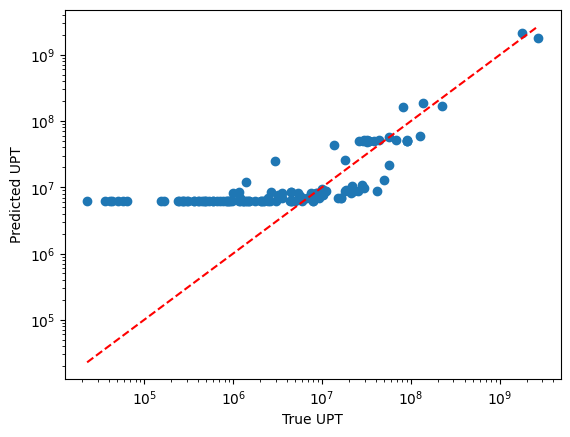

In [133]:
fig, ax = plt.subplots()
ax.scatter(y_test, tree_rail.predict(X_test))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("True UPT")
ax.set_ylabel("Predicted UPT")
plt.show()

Not using the transformed predictors shows us a pretty skewed set of predictions, in which we see a hard floor to the predictions even though we have test data point going down all the way to $10^4$. Above a certain value, the predictions do well, but the large range of magnitudes might by stymying the calculation of the $R^2$ values. Let's try out transformed dataset.

In [126]:
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_trans_reg.drop(columns=['UPT']),
                                                            X_trans_reg['UPT'], random_state=1)

In [127]:
tree_t_rail = RandomForestRegressor(max_depth=3, random_state=1)
tree_t_rail.fit(X_t_train, y_t_train)

RandomForestRegressor(max_depth=3, random_state=1)

Model R-squared: 0.8632622455653328


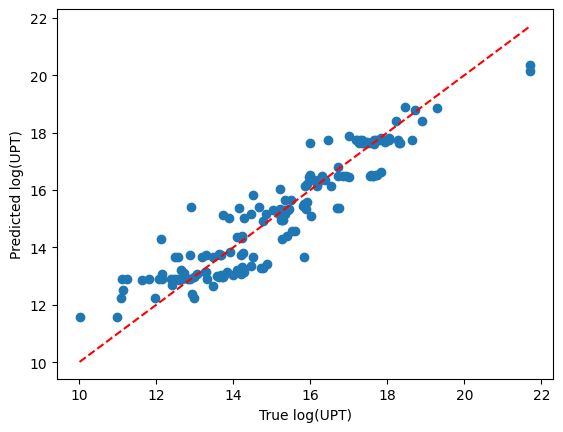

In [131]:
t_predict = tree_t_rail.predict(X_t_test)
print(f"Model R-squared: {r2_score(y_t_test, t_predict)}")
fig, ax = plt.subplots()
ax.scatter(x = y_t_test, y = t_predict)
ax.plot([y_t_test.min(), y_t_test.max()], [y_t_test.min(), y_t_test.max()], 'r--')
ax.set_xlabel("True log(UPT)")
ax.set_ylabel("Predicted log(UPT)")
plt.show()

Our random forest regression does excellently, and quite similarly to our linear regression model. There is the possibility that the model stops working very well at the upper and lower end of the fit, but it would be hard to evaluate that without more very large and very small transit agencies. Next question: what features is the random forest latching on to?

In [140]:
key_feats = tree_t_rail.feature_importances_
pd.Series(key_feats, index=X_t_train.columns).sort_values(ascending=False)

Mode VOMS                 0.884647
Total Minor Injuries      0.036011
Total Injuries            0.030670
Primary UZA Population    0.022279
Fare                      0.016620
Total Spending            0.004799
Total Fatalities          0.002813
Total Serious Injuries    0.002161
Property Damage           0.000000
dtype: float64

Almost exclusibely VOMS. If we take that out and try again, what does it fixate on?

In [142]:
tree_rail_noVOMS = RandomForestRegressor(max_depth=3, random_state=1)
tree_rail_noVOMS.fit(X_t_train.drop(columns=['Mode VOMS']), y_t_train)

RandomForestRegressor(max_depth=3, random_state=1)

In [146]:
t_noVOMS_predict = tree_rail_noVOMS.predict(X_t_test.drop(columns=['Mode VOMS']))
print(f"Model R-squared: {r2_score(y_t_test, t_noVOMS_predict)}")
key_feats = tree_rail_noVOMS.feature_importances_
pd.Series(key_feats, index=X_t_train.drop(columns=['Mode VOMS']).columns).sort_values(ascending=False)

Model R-squared: 0.7900745995571216


Total Spending            0.672153
Total Minor Injuries      0.153102
Total Injuries            0.121108
Primary UZA Population    0.045330
Fare                      0.003742
Total Serious Injuries    0.002863
Total Fatalities          0.001597
Property Damage           0.000104
dtype: float64

We do better than regression on the same data, and now it focuses the most on total spending, folloed by the injury columns. Fare seems to be almost unimportant, and the fatalities and property damage from accidents are practically irrelevant.